In [15]:
from tensorflow import keras
import tensorflow as tf
tf.get_logger().setLevel('WARNING')
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split

### Data preparation

In [16]:
hop_length = 1024
n_fft = 1024
n_mels = 48
n_mfcc = 13
sr = 16000

In [32]:
def ProcessData(music_dir):
    x_res = [[] for i in range(10)]
    y_res = [[] for i in range(10)]

    for genre_id, genre in enumerate(os.listdir(music_dir)):
        for song in os.listdir(music_dir + genre):
            song_path = music_dir + genre + "/" + song

            audio, _ = librosa.load(song_path, sr=sr)

            audio *= 2**15 # convert to 16-bit

            result = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft, center=False)

            for i in range(result.shape[1] // 128):
                res = result[:, i*128:(i+1)*128]
                x_res[genre_id].append(res)
                y_res[genre_id].append(np.eye(10)[genre_id])
    
    return x_res, y_res
    
arduino_dir = "gtzan/Data/genres_arduino/"
original_dir = "gtzan/Data/genres_original/"

arduino_x, arduino_y = ProcessData(arduino_dir)
original_x, original_y = ProcessData(original_dir)

#take first half of arduino data and second half of original data for each genre
x = []
y = []
for i in range(10):
    x.extend(arduino_x[i][:len(arduino_x[i])//2] + original_x[i][len(original_x[i])//2:])
    y.extend(arduino_y[i][:len(arduino_y[i])//2] + original_y[i][len(original_y[i])//2:])

#normalize data by mean and std of whole set
mfcc_avg = np.mean(x, axis=(0,2))
mfcc_std = np.std(x, axis=(0,2))
for i in range(len(x)):
    x[i] = ( (x[i].T - mfcc_avg) / mfcc_std ).T

print("mffc avg:", list(mfcc_avg.astype(np.float32)))
print("mffc std:", list(mfcc_std.astype(np.float32)))
print("Min:", np.min(x), "Max:", np.max(x), "Avg:", np.mean(x), "Std:", np.std(x))
print("Number of samples:", len(x))

mffc avg: [446.02563, 36.123276, -7.691543, 14.370121, -0.68318045, 5.825986, 3.0853918, -0.99041206, 4.941904, 5.33153, 4.3454432, 5.936014, 2.1101217]
mffc std: [91.35619, 29.026442, 20.318783, 12.534469, 10.299112, 8.434362, 7.7773743, 7.7836747, 8.236834, 7.762929, 7.3308835, 7.83173, 7.062603]
Min: -7.131892 Max: 7.2256107 Avg: -1.9370228e-07 Std: 0.9999995
Number of samples: 3309


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = np.array(x_train).reshape(-1, 13, 128, 1).astype(np.float32)
y_train = np.array(y_train).reshape(-1, 10)
x_test = np.array(x_test).reshape(-1, 13, 128, 1).astype(np.float32)
y_test = np.array(y_test).reshape(-1, 10)

print("Training samples:", x_train.shape[0], "  Testing samples:", x_test.shape[0])

Training samples: 2647   Testing samples: 662


In [7]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(24, (3, 3), activation='relu', input_shape=(13, 128, 1)))
model.add(keras.layers.MaxPooling2D((2, 2), padding='same'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Conv2D(24, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2), padding='same'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Conv2D(24, (2, 2), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2), padding='same'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(48, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

print(model.count_params())
model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), verbose=1)
model.save('model.h5')
history = model.history.history

25594
Epoch 1/100
83/83 [==============================] - 3s 23ms/step - loss: 2.2934 - accuracy: 0.1315 - val_loss: 2.1940 - val_accuracy: 0.1873
Epoch 2/100
83/83 [==============================] - 2s 20ms/step - loss: 2.1164 - accuracy: 0.1953 - val_loss: 2.0544 - val_accuracy: 0.2432
Epoch 3/100
83/83 [==============================] - 2s 20ms/step - loss: 1.9921 - accuracy: 0.2471 - val_loss: 1.9700 - val_accuracy: 0.2523
Epoch 4/100
83/83 [==============================] - 2s 20ms/step - loss: 1.8928 - accuracy: 0.2830 - val_loss: 1.8478 - val_accuracy: 0.3323
Epoch 5/100
83/83 [==============================] - 2s 20ms/step - loss: 1.7181 - accuracy: 0.3408 - val_loss: 1.7619 - val_accuracy: 0.3172
Epoch 6/100
83/83 [==============================] - 2s 20ms/step - loss: 1.6316 - accuracy: 0.3823 - val_loss: 1.7193 - val_accuracy: 0.3505
Epoch 7/100
83/83 [==============================] - 2s 20ms/step - loss: 1.5291 - accuracy: 0.4333 - val_loss: 1.5978 - val_accuracy: 0.4215


21/21 - 0s - loss: 0.8441 - accuracy: 0.7145 - 102ms/epoch - 5ms/step

Test accuracy: 71.45015001296997%, thats 61.45015001296997% better than random chance


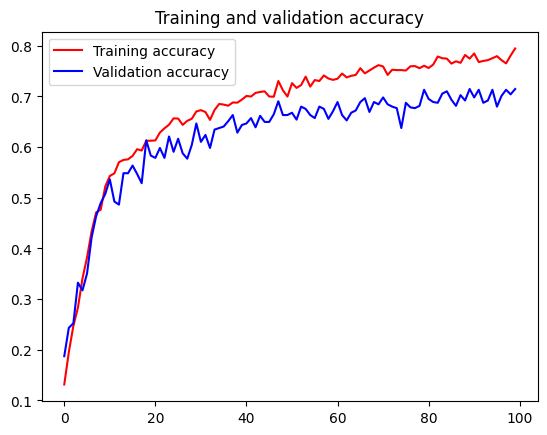

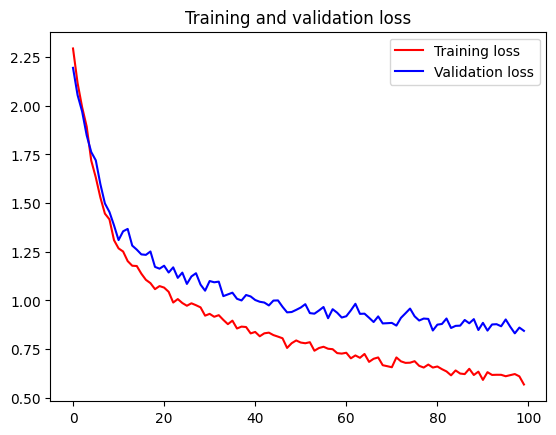

<Figure size 640x480 with 0 Axes>

In [8]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy: {}%, thats {}% better than random chance'.format(test_acc*100, test_acc*100-10))

epochs = range(len(history['accuracy']))

plt.plot(epochs, history['accuracy'], 'r', label='Training accuracy')
plt.plot(epochs,  history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, history['loss'], 'r', label='Training loss')
plt.plot(epochs,  history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

21/21 [==============================] - 0s 4ms/step


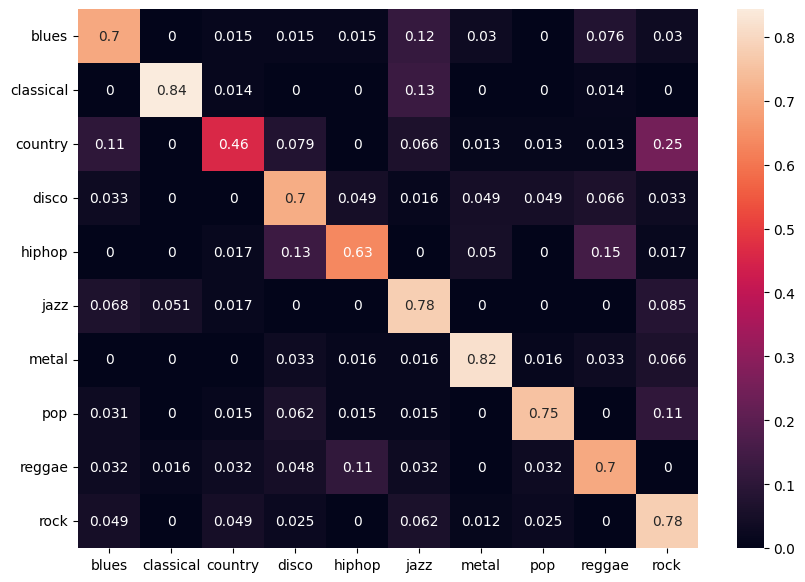

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
model = keras.models.load_model('model.h5')

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_c = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_c, y_pred, normalize='true')

df_cm = pd.DataFrame(cm, index = [i for i in "blues classical country disco hiphop jazz metal pop reggae rock".split()],
                    columns = [i for i in "blues classical country disco hiphop jazz metal pop reggae rock".split()])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

plt.show()

### Quantization / Model Reduction

In [10]:
def representative_dataset():
    for i in range(1000):
        yield [x_train[i].reshape(1, 13, 128, 1)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_quant_model = converter.convert()

open("model.tflite", "wb").write(tflite_quant_model)

print("Original model in Mb:", os.path.getsize('model.h5') / float(2**20))
print("Quantized model in Mb:", os.path.getsize('model.tflite') / float(2**20))

C:\Users\danif\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Original model in Mb: 0.3445281982421875
Quantized model in Mb: 0.03133392333984375


In [12]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input details:", "\nshape - ", input_details[0]['shape'], "\ntype -", input_details[0]['dtype'], "\nquantization -", input_details[0]['quantization'])
print("\nOutput details:", "\nshape - ", output_details[0]['shape'], "\ntype -", output_details[0]['dtype'], "\nquantization -", output_details[0]['quantization'])

input_scale, input_zero_point = input_details[0]["quantization"]
input_shape = input_details[0]['shape']
output_scale, output_zero_point = output_details[0]["quantization"]
acc=0
for i in range(len(x_test)):
    input_data = x_test[i].reshape(input_shape)
    input_data = ( input_data / input_scale + input_zero_point ).astype(np.uint8)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    output_data = (output_data.astype(float) - output_zero_point) * output_scale
    if(np.argmax(output_data) == np.argmax(y_test[i])):
        acc+=1
acc = acc/len(x_test)

print("\nQuantized test accuracy: {}%, thats {}% better than random chance".format(acc*100, acc*100-10))

Input details: 
shape -  [  1  13 128   1] 
type - <class 'numpy.uint8'> 
quantization - (0.05118812993168831, 114)

Output details: 
shape -  [ 1 10] 
type - <class 'numpy.uint8'> 
quantization - (0.00390625, 0)

Quantized test accuracy: 70.99697885196375%, thats 60.996978851963746% better than random chance


In [13]:
correct = 0
total = 0
for genre_id in range(10):
    for i in range(len(arduino_y[genre_id])//2, len(arduino_y[genre_id])):
        #res = result[:, i*128:(i+1)*128]
        res = arduino_x[genre_id][i]
        res =  ( (res.T - mfcc_avg) / mfcc_std ).T # normalize ( mean and std of whole set )

        input_data = res.reshape(input_shape)
        input_data = ( input_data / input_scale + input_zero_point ).astype(np.uint8)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        output_data = (output_data.astype(float) - output_zero_point) * output_scale
        #print(np.argmax(output_data), end=" ")
        if(np.argmax(output_data) == genre_id):
            correct+=1
        total+=1
print("Arduino accuracy", correct/total)

correct = 0
total = 0
for genre_id in range(10):
    for i in range(0, len(original_y[genre_id])//2):
        #res = result[:, i*128:(i+1)*128]
        res = original_x[genre_id][i]
        res =  ( (res.T - mfcc_avg) / mfcc_std ).T

        input_data = res.reshape(input_shape)
        input_data = ( input_data / input_scale + input_zero_point ).astype(np.uint8)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        output_data = (output_data.astype(float) - output_zero_point) * output_scale
        #print(np.argmax(output_data), end=" ")
        if(np.argmax(output_data) == genre_id):
            correct+=1
        total+=1
print("Original data accuracy", correct/total)

Arduino accuracy 0.6911602209944752
Original data accuracy 0.5373831775700935


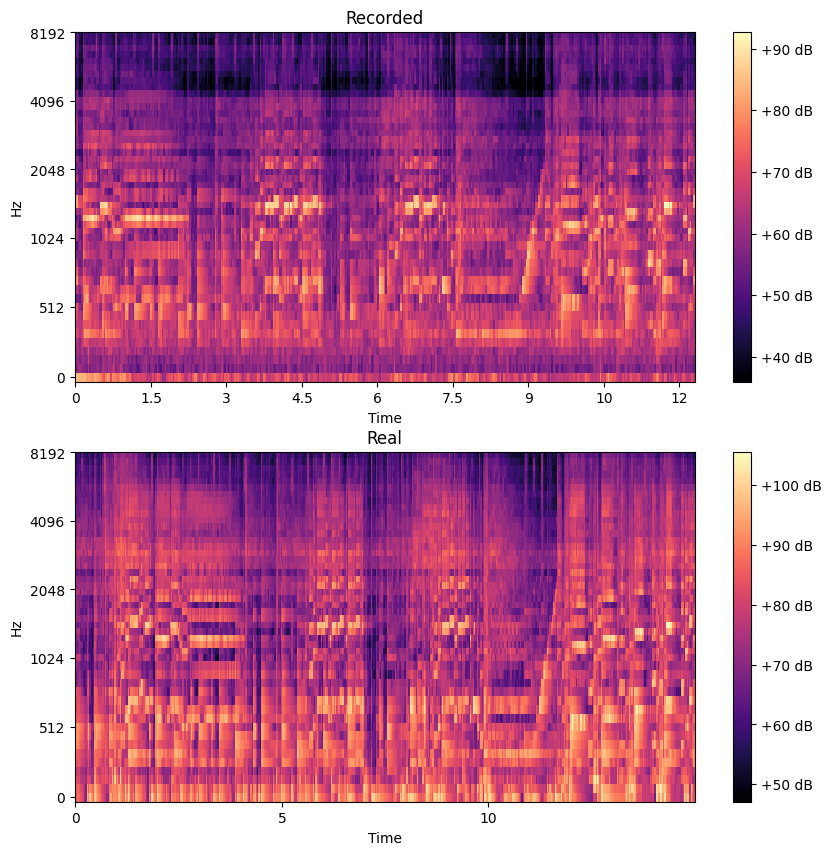

In [262]:
recorded, sr = librosa.load("test_audio/sound5.wav", sr=16000)
real, sr = librosa.load("test_audio/jazz.00085.wav", sr=16000)
noise_factor = 0.0005
white_noise = np.random.randn(len(real)) * noise_factor
real += white_noise

recorded *= 2**15
real *= 2**15
#plot mel spectrogram of both
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
S = librosa.feature.melspectrogram(y=recorded, sr=sr, n_mels=48, n_fft=1024, hop_length=1024)
S_dB = librosa.power_to_db(S)[:,50:]
img1 = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax1)
ax1.set(title='Recorded')
fig.colorbar(img1, ax=ax1, format='%+2.0f dB')
S = librosa.feature.melspectrogram(y=real, sr=sr, n_mels=48, n_fft=1024, hop_length=1024)
S_dB = librosa.power_to_db(S)
img2 = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000, ax=ax2)
ax2.set(title='Real')
fig.colorbar(img2, ax=ax2, format='%+2.0f dB')
#plt.show()


In [14]:
# Convert to C array
# taken from: https://nuclearrambo.com/wordpress/converting-a-binary-data-file-into-a-c-array-with-python/
import re

def bytes_to_c_arr(data):
    return [format(b, '#04x') for b in data]
 
def read_file(file_name):
    data = np.fromfile(file_name, dtype='uint8')
    data = bytearray(data)
    return data
 
def write_c_array(file_name, data):
    c_file = open(file_name + ".h", "w")
    static_content = "unsigned char array[" + str(len(data)) + "] = "
    array_content = "{{{}}}".format(", ".join(bytes_to_c_arr(data)))
    final_content = static_content + array_content
    final_content = re.sub("(.{72})", "\\1\n", final_content, 0, re.DOTALL)
    final_content = "alignas(8) const " + final_content + ";"
    c_file.write(final_content)

raw_data = read_file("model.tflite")
write_c_array("model_data", raw_data)